In [1]:
# importing required libraries
using JuMP, Ipopt, Plots, LaTeXStrings

# Part 1 - Supersonic Inlet Optimization

In [2]:
# defining gas dynamics helper functions
function oblique_shock_deflection(M, β; γ=1.4)
    num = M^2 * sin(β)^2 - 1
    den = M^2 * (γ+1)/2 - (M^2 * sin(β)^2 - 1)
    θ = atan(cot(β) * num / den)

    return θ
end

function post_oblique_mach(M, β; γ=1.4)
    term1 = (1 + M^2 * (γ-1)/2)/(γ*M^2*sin(β)^2 - (γ-1)/2)
    term2 = (M^2 * cos(β)^2)/(1 + M^2 * sin(β)^2 * (γ-1)/2)
    
    M_2 = sqrt(term1 + term2)
    
    return M_2
end

function oblique_P0_ratio(M, β; γ=1.4)
    P_ratio = (2 * γ * M^2 * sin(β)^2)/(γ + 1) - (γ-1)/(γ+1)
    ρ_ratio = ((γ + 1) * M^2 * sin(β)^2) / ((γ - 1) * M^2 * sin(β)^2 + 2)
    T_ratio = P_ratio / ρ_ratio
    
    P0_ratio = P_ratio * (T_ratio)^(γ / (1 - γ))
    
    return P0_ratio
end

function normal_P0_ratio(M; γ=1.4)
    term1 = ((M^2 * (γ+1) / 2) / (1 + M^2 * (γ-1) / 2))^(γ / (γ - 1))
    term2 = (1 / (M^2 * 2*γ / (γ+1) - (γ-1)/(γ+1)))^(1 / (γ - 1))

    return term1*term2
end;

In [3]:
# constants
const M1 = 2.4
const Mn = 1.3
const γ = 1.4
const R = 287.15
const πn = normal_P0_ratio(Mn);

In [4]:
# initializing model and registering functions for use in optimization
model = Model(Ipopt.Optimizer)

register(model, :post_oblique_mach, 2, post_oblique_mach, autodiff=true)
register(model, :oblique_shock_deflection, 2, oblique_shock_deflection, autodiff=true)
register(model, :oblique_P0_ratio, 2, oblique_P0_ratio, autodiff=true)

In [5]:
# defining control variables
@variables(model, begin
    β1 >= 0.2
    β2 >= 0.2
    β3 >= 0.2
end);

In [6]:
# defining expressions for deflection angles, mach numbers, and stagnation pressure ratios
@NLexpressions(model, begin
    # first shock
    θ1, oblique_shock_deflection(M1, β1)
    π1, oblique_P0_ratio(M1, β1)
        
    # second shock
    M2, post_oblique_mach(M1, β1)
    θ2, oblique_shock_deflection(M2, β2)
    π2, oblique_P0_ratio(M2, β2)

    # last shock
    M3, post_oblique_mach(M2, β2)
    θ3, oblique_shock_deflection(M3, β3)
    π3, oblique_P0_ratio(M3, β3)
end);

In [7]:
# defining constraints
@NLconstraints(model, begin
    post_oblique_mach(M3, β3) == Mn
    M2 >= 1
    M3 >= 1
    0 <= θ1 + θ2 + θ3 <= π/2
end);

In [8]:
# objective definition
@NLobjective(model, Max, π1 * π2 * π3 * πn)

In [9]:
# summary of model
model

A JuMP Model
Maximization problem with:
Variables: 3
Objective function type: Nonlinear
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
Nonlinear: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: M2, M3, β1, β2, β3, θ1, θ2, θ3, π1, π2, π3

In [10]:
# optimization
set_silent(model)
optimize!(model)

# printing result
solution_summary(model, verbose=true)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



* Solver : Ipopt

* Status
  Termination status : LOCALLY_SOLVED
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Result count       : 1
  Has duals          : true
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution
  Objective value      : 0.9339433812576962
  Primal solution :
    β1 : 0.5573768306822287
    β2 : 0.6695886794158181
    β3 : 0.8534322167985908
  Dual solution :

* Work counters
  Solve time (sec)   : 4.61600


## Analysis

In [11]:
# checking oswatisch principle
value(M1) * sin(value(β1)), value(M2) * sin(value(β2)), value(M3) * sin(value(β3))

(1.2695085103404735, 1.2695085102814068, 1.269508509070954)

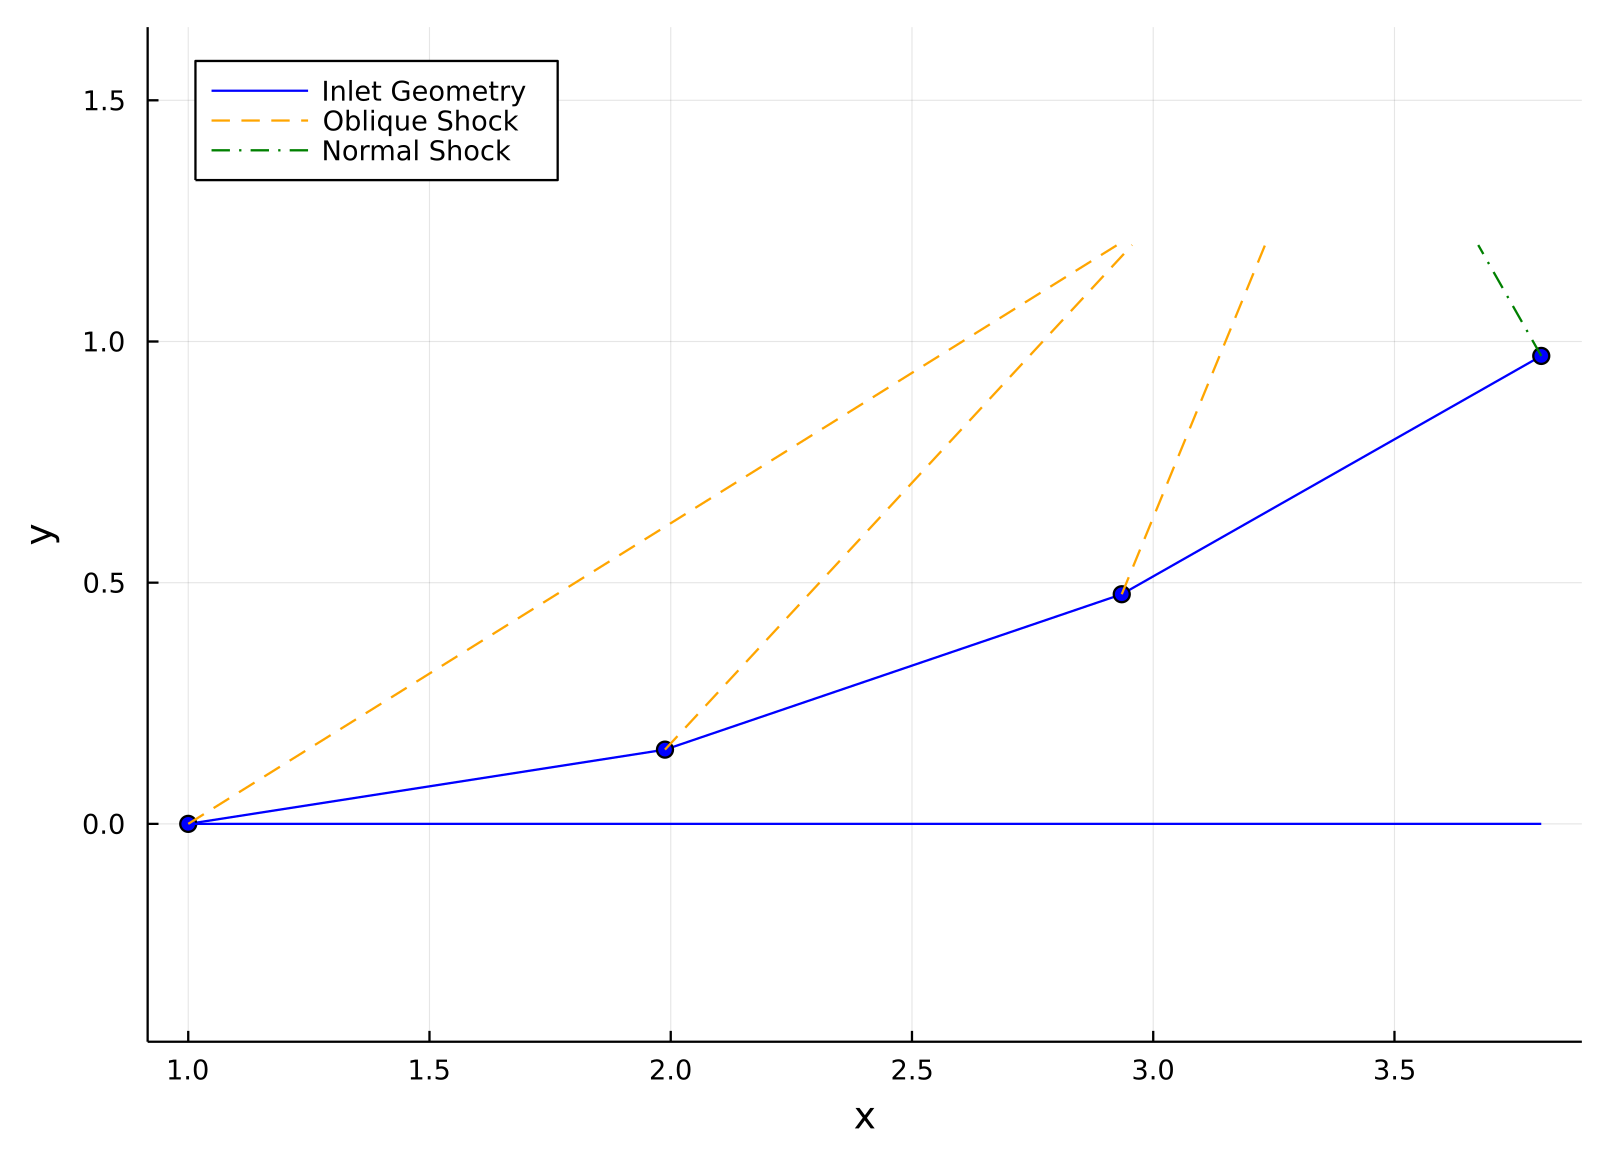

In [12]:
# visualizing geometry
β_vals = value.([β1, β2, β3])
θ_vals = value.([θ1, θ2, θ3])
    
geom_x = [1.0]
geom_y = [0.0]
θ_csum = cumsum(θ_vals)

for i ∈ 1:length(θ_csum)
    push!(geom_x, geom_x[i] + cos(θ_csum[i]))
    push!(geom_y, geom_y[i] + sin(θ_csum[i]))
end

# physical geometry
height=1.2

fig = plot(
    geom_x, 
    geom_y, 
    aspect_ratio=:equal, 
    label="Inlet Geometry", 
    color=:blue, 
    dpi=230, 
    size=(700, 500),
    xlabel="x",
    ylabel="y",
    legend=:topleft,
    fmt = :png
)

scatter!(geom_x, geom_y, label="", color=:blue)
#plot!([1, geom_x[end]], [height, height], label="", color=:blue)
plot!([1, geom_x[end]], [0, 0], label="", color=:blue)

# shocks
plot!(
    [geom_x[1], geom_x[1] + ((height-geom_y[1])/sin(β_vals[1]))*cos(β_vals[1])], 
    [geom_y[1], height], 
    label="Oblique Shock", 
    linestyle=:dash,
    color=:orange
)

plot!(
    [geom_x[2], geom_x[2] + ((height-geom_y[2])/sin(β_vals[2]+θ_csum[1]))*cos(β_vals[2]+θ_csum[1])], 
    [geom_y[2], height], 
    label="", 
    linestyle=:dash,
    color=:orange
)
plot!(
    [geom_x[3], geom_x[3] + ((height-geom_y[3])/sin(β_vals[3]+θ_csum[2]))*cos(β_vals[3]+θ_csum[2])], 
    [geom_y[3], height], 
    label="", 
    linestyle=:dash,
    color=:orange
)

plot!(
    [geom_x[4], geom_x[4] + ((height-geom_y[4])/sin(θ_csum[3] + π/2))*cos(θ_csum[3] + π/2)], 
    [geom_y[4], height], 
    label="Normal Shock", 
    linestyle=:dashdot,
    color=:green
)

## Variable Inlet Geometry

In [13]:
n = 120
M1_vec = LinRange(2.2, 2.6, n);

In [14]:
# initializing model and registering functions for use in optimization
var_model = Model(Ipopt.Optimizer)

register(var_model, :post_oblique_mach, 2, post_oblique_mach, autodiff=true)
register(var_model, :oblique_shock_deflection, 2, oblique_shock_deflection, autodiff=true)
register(var_model, :oblique_P0_ratio, 2, oblique_P0_ratio, autodiff=true)

In [15]:
# defining control variables
@variables(var_model, begin
    β1_vec[1:n] >= 0.47
    β2_vec[1:n] >= 0.47
    β3_vec[1:n] >= 0.47
end)

@NLexpressions(var_model, begin
    θ1_vec[j = 1:n], oblique_shock_deflection(M1_vec[j], β1_vec[j])
    π1_vec[j = 1:n], oblique_P0_ratio(M1_vec[j], β1_vec[j])

    M2_vec[j = 1:n], post_oblique_mach(M1_vec[j], β1_vec[j])
    θ2_vec[j = 1:n], oblique_shock_deflection(M2_vec[j], β2_vec[j])
    π2_vec[j = 1:n], oblique_P0_ratio(M2_vec[j], β2_vec[j])

    M3_vec[j = 1:n], post_oblique_mach(M2_vec[j], β2_vec[j])
    θ3_vec[j = 1:n], oblique_shock_deflection(M3_vec[j], β3_vec[j])
    π3_vec[j = 1:n], oblique_P0_ratio(M3_vec[j], β3_vec[j])
end);

# defining constraints
for i in 1:n  
    @NLconstraints(var_model, begin
        post_oblique_mach(M3_vec[i], β3_vec[i]) == Mn
        M2_vec[i] >= 1
        M3_vec[i] >= 1
        0 <= θ1_vec[i] + θ2_vec[i] + θ3_vec[i] <= π/2
    end);
end

# objective definition
@NLobjective(var_model, Max, sum(π1_vec[i] * π2_vec[i] * π3_vec[i] * πn for i in 1:n))

In [16]:
# optimization
set_silent(var_model)
optimize!(var_model)

# printing result
solution_summary(var_model)

* Solver : Ipopt

* Status
  Termination status : LOCALLY_SOLVED
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution
  Objective value      : 111.93429809460207

* Work counters
  Solve time (sec)   : 0.36000


In [17]:
# checking πt at M1 ~ 2.4
M1_vec[61], value.(π1_vec)[61] * value.(π2_vec)[61] * value.(π3_vec)[61] * πn

(2.401680672268908, 0.9337453831253852)

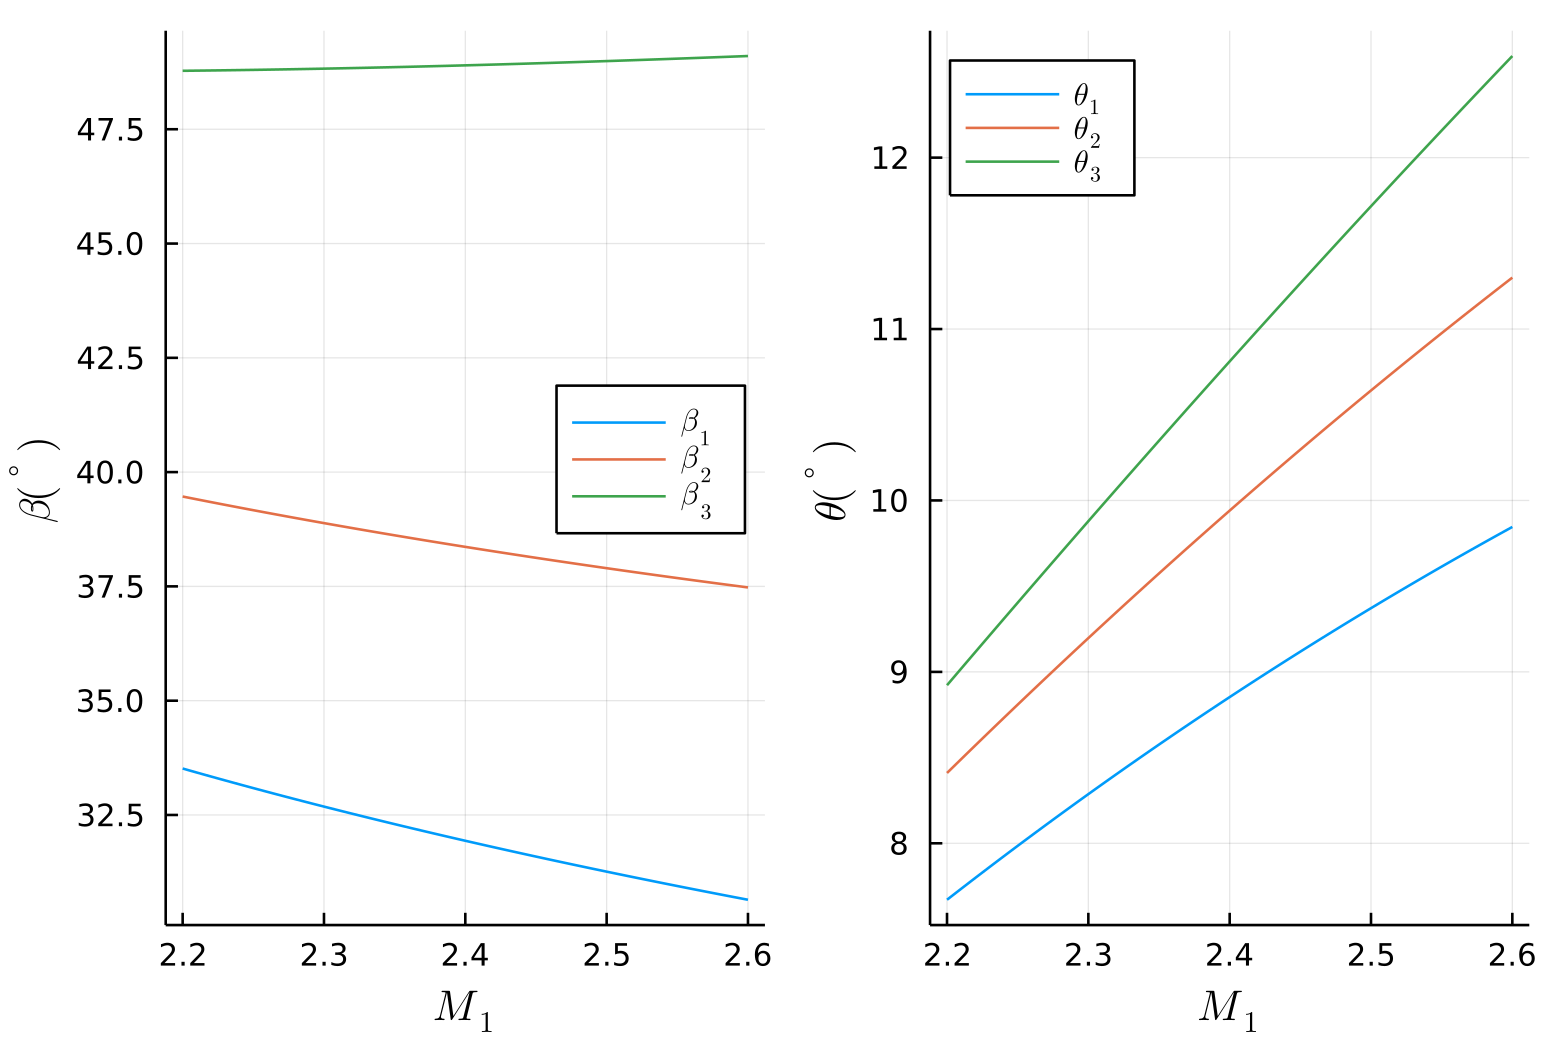

In [31]:
β1_vals = rad2deg.(value.(β1_vec))
β2_vals = rad2deg.(value.(β2_vec))
β3_vals = rad2deg.(value.(β3_vec))

θ1_vals = rad2deg.(value.(θ1_vec))
θ2_vals = rad2deg.(value.(θ2_vec))
θ3_vals = rad2deg.(value.(θ3_vec))

fig2 = plot(
    M1_vec, 
    β1_vals, 
    label=L"\beta_1", 
    xlabel=L"M_1",
    ylabel=L"\beta (^\circ)",
    size=(600,400),
    legend=:right,
    fmt = :png
)

plot!(M1_vec, β2_vals, label=L"\beta_2")
plot!(M1_vec, β3_vals, label=L"\beta_3")

fig21 = plot(M1_vec, 
    θ1_vals, 
    label=L"\theta_1", 
    xlabel=L"M_1",
    ylabel=L"\theta (^\circ)",
    legend=:topleft,
    size=(600,400),
    tex_output_standalone = true,
    fmt = :png
)

plot!(M1_vec, θ2_vals, label=L"\theta_2")
plot!(M1_vec, θ3_vals, label=L"\theta_3")

fig2c = plot(fig2, fig21, layout=2, dpi=260)

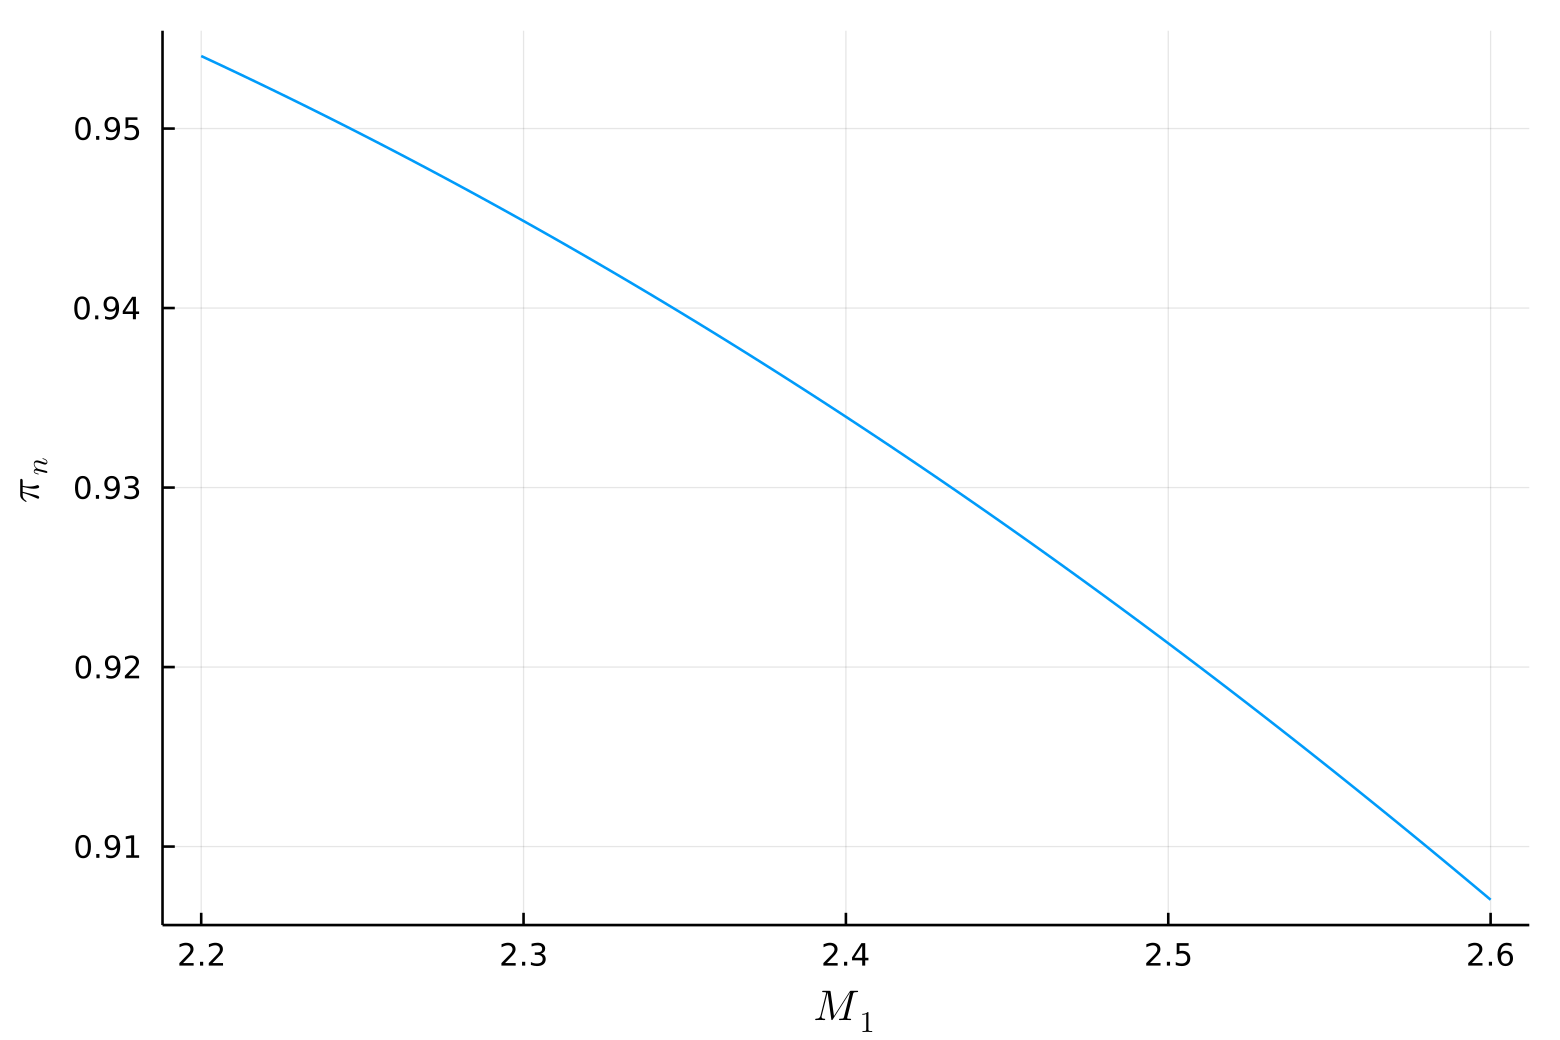

In [28]:
π_vals = value.(π1_vec) .* value.(π2_vec) .* value.(π3_vec) .* πn

fig3 = plot(
    M1_vec,
    π_vals,
    label="",
    tex_output_standalone = true,
    xlabel=L"M_1",
    ylabel=L"\pi_n",
    fmt=:png,
    dpi=260
)

# Part 2 - Parametric Cycle Analysis

In [20]:
# defining inputs
Ma = 2.4

Ta = 218.9222
Pa = 23911.018293

# introduction to aerospace materials
# refractory intermetallics based on metal silicides (Mo5Si3, Nb5Si3, Ti5Si3)
T04 = 1300 + 273.15

# kerosene: http://www.thermalfluidscentral.org/encyclopedia/index.php/Heat_of_Combustion
QR = 46.20e6

A_i = 0.4103218

π_B = 0.97
π_n = 0.98
η_B = 0.95

# πd = 0.9339433812576962
πd = value(π1) * value(π2) * value(π3) * πn;

In [21]:
T_ratio_a = 1 + (Ma^2) * (γ - 1)/2
P_ratio_a = T_ratio_a^(γ / (γ - 1))
ua = Ma * sqrt(γ * R * Ta)

T0a = T_ratio_a * Ta
P0a = P_ratio_a * Pa

T02 = T0a
T03 = T02

P02 = πd * P0a

f = (T04/T03 - 1) / (η_B * QR / (1004*T03) - T04 / T03)
P04 = π_B * P02

P07 = π_n * P04

M7= sqrt(((P07/Pa)^((γ-1)/γ) - 1)*2/(γ-1))

T07 = T04
T7 = T07 / (1 + M7^2 * (γ-1)/2)
u7 = M7 * sqrt(γ * R * T7)

ṁa = (Pa / (R*Ta)) * ua * A_i

Th = ṁa * ((1 + f)*u7 - ua)

TSFC = f * ṁa / Th

ηo = Th * ua / (f * ṁa * QR)

ṁf = f*ṁa;

## Trade Study

In [22]:
# improvements
data = [
    [0.61, πd],
    [0.89, η_B],
    [13.12, Th/1e3],
    [0.083485, TSFC],
    [1.329, ṁf]
]

for measure in data
    println(100 * (measure[2] - measure[1]) / measure[1])
end

53.105472337327235
6.741573033707859
410.62370748700533
-99.94804426343734
118.651160262673


In [23]:
# aircraft range
m2 = 92080
m1 = 185000
LD_ratio = 7

T2 = 13.12e3
ṁf2 = 1.329

s1 = LD_ratio * (Th / ṁf) * (ua / 9.80665) * log(m1 / m2)
s2 = LD_ratio * (T2 / ṁf2) * (ua / 9.80665) * log(m1 / m2);

s1/1e3, s2/1e3

(8174.8067419026975, 3500.485686097202)

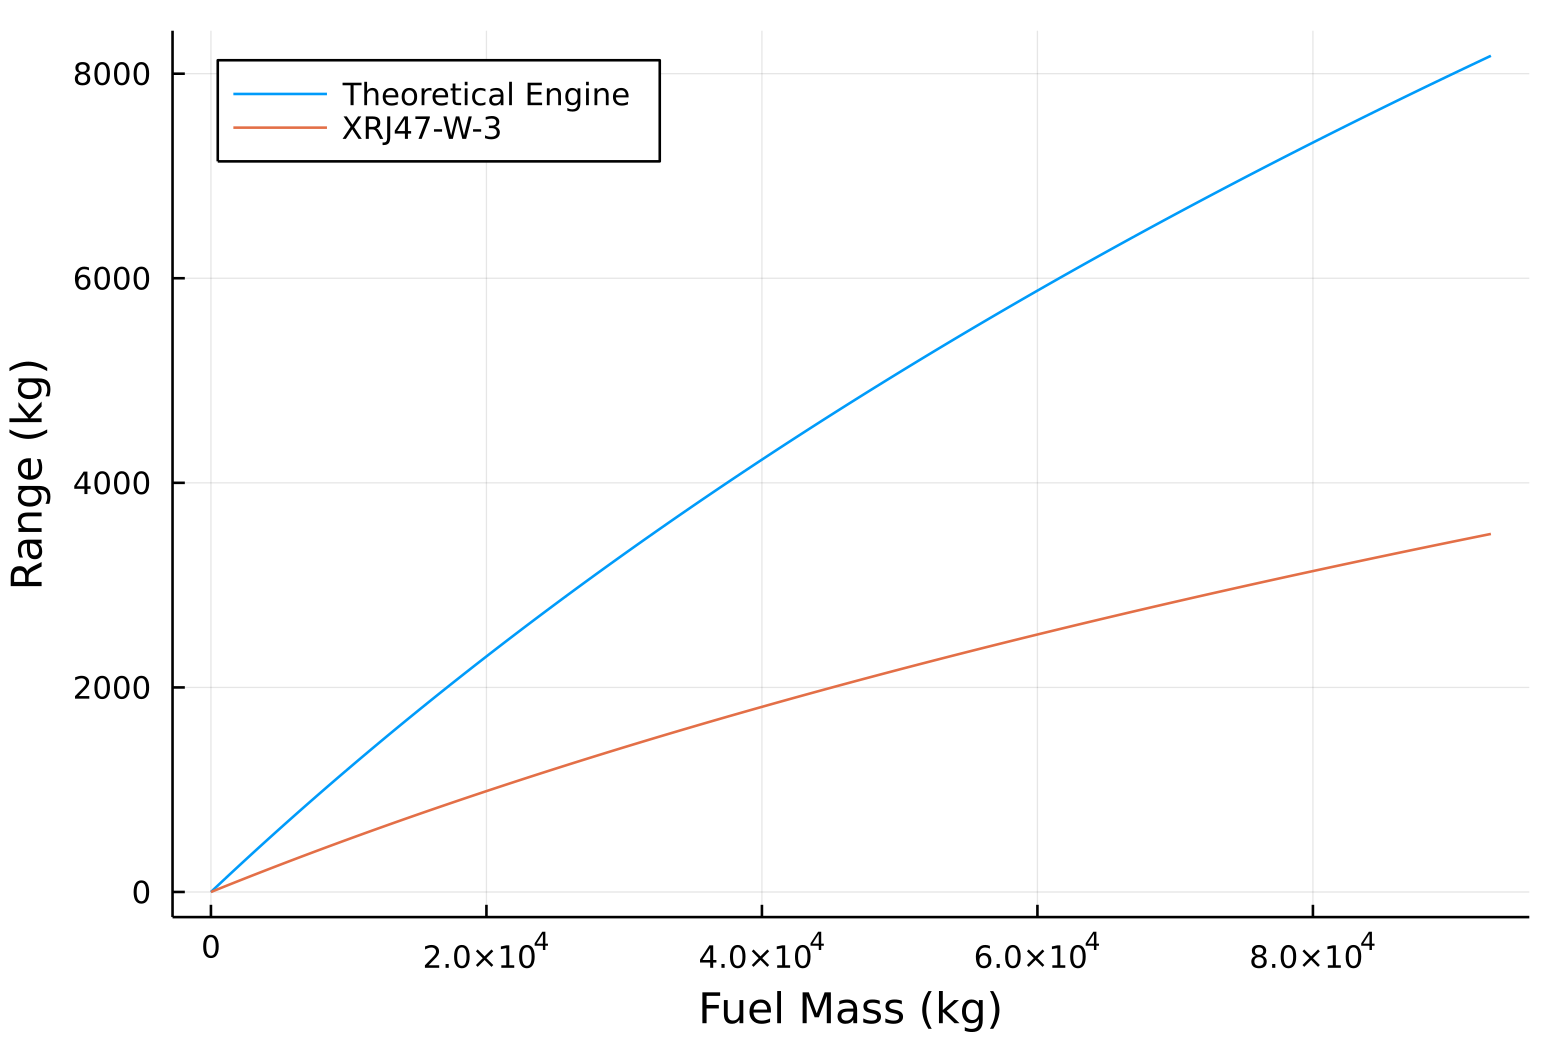

In [27]:
masses = LinRange(m1, m2, 500)

s1_vec = LD_ratio * (Th / ṁf) * (ua / 9.80665) .* log.(masses / m2)
s2_vec = LD_ratio * (T2 / ṁf2) * (ua / 9.80665) .* log.(masses / m2)

fig4 = plot(
    masses .- m2, s1_vec./1e3, 
    label="Theoretical Engine", 
    legend=:topleft,
    xlabel="Fuel Mass (kg)",
    ylabel="Range (kg)",
    fmt=:png,
    dpi=260
)

plot!(masses .- m2, s2_vec./1e3, label="XRJ47-W-3")